In [4]:
import random
import copy
import numpy as np
import theano as T
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

In [5]:
%%capture  --no-stderr --no-stdout --no-display
%%R

library(ggplot2)
library(reshape)
library(grid)
library(dplyr)
library(gridExtra)
library(lme4)

/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Need help getting started? Try the cookbook for R:
http://www.cookbook-r.com/Graphs/

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:reshape’:

    rename


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/pyth

In [15]:
%%R --o data_resp

data_resp_loc <- read.csv("data/estimation_dot_gaze.csv", sep="\t")
data_tracker <- read.csv("data/estimation_tracker_data.csv", sep="\t")
data_tracker$trial_id <- data_tracker$trial_id - 1
data_resp_loc$trial_id <- data_resp_loc$trial_id - 1


data_resp_loc <- data_resp_loc %>%
                filter(belowX >= 0)

trials <- (unique(data_resp_loc$trial_id))

data_tracker <- data_tracker %>%
                group_by(trial_id) %>%
                filter(trial_id %in% trials)


data_resp_loc$id <- seq.int(1, nrow(data_resp_loc))


data_resp <- data_resp_loc %>%
      filter(gazeDist > 0 & Dots_Shown < 150 & Dots_Shown > 10) %>%
      mutate(err=Dots_Counted - Dots_Shown) %>%
      mutate(abs_err = abs(err)) %>%
      mutate(within_x = 1/(1 + exp(-0.1*belowX))) %>%
      group_by(trial_id) %>% 
      mutate(belowX = mean(belowX)) %>%
      mutate(within_x = mean(within_x)) %>%
      mutate(within_x_tot = sum(within_x)) %>%

      mutate(mean_dist=sum(gazeDist)/Dots_Shown) %>%
      mutate(mean_abs_err = mean(abs_err)) %>%
      mutate(pct_err=err/Dots_Shown) %>%
        mutate(abs_pct_err=abs_err/Dots_Shown) %>%

      top_n(n=1, wt=id) %>% 
      filter(abs_pct_err < 1.0) %>%
      filter(within_x > 0)









data_tracker <- data_tracker %>%
                  filter(ValidityLeft == 0 & ValidityRight == 0) %>%

                mutate(av_x = (GazePointXLeft +GazePointXRight)/2) %>%
                mutate(av_y = (GazePointYLeft +GazePointYRight)/2) %>%
                group_by(trial_id) %>%
                mutate(Time = round(max(TimeStamp)/100)/10)

data_tracker$id <- seq.int(1,nrow(data_tracker))
data_resp$Time <- as.factor(round(data_resp$Time,2))



In [16]:
data_resp = pandas2ri.ri2py(data_resp)

In [63]:

time = data_resp["Time"]
dots_shown = np.array(data_resp["Dots_Shown"])
dots_counted = np.array(data_resp["Dots_Counted"])
pct_area = np.array(data_resp["pctArea"])
tot_area = data_resp["totArea"]
within_x = data_resp["within_x"]
seen = np.array(data_resp["within_x_tot"])
unseen = dots_shown - seen

with pm.Model() as mod:
    b_seen = pm.Normal("b_seen", mu=0,sd=10,testval=0.5)
    b_unseen = pm.Normal("b_unseen", mu=0,sd=10,testval=0.5)
    alpha = pm.Beta("alpha", 0.01,0.01)
    
    guess_mean = b_seen * seen * (1/pct_area) ** alpha + b_unseen * unseen
    
    b_noise_seen = pm.Normal("noise_seen", mu=0, sd=10, testval=1)
    b_noise_unseen = pm.Normal("noise_unseen", mu=0, sd=10, testval=1)

    noise_mean = b_noise_seen * seen + b_noise_unseen * unseen
    
    lkhd = pm.Normal("lkhd", mu=guess_mean, sd=noise_mean, observed=dots_counted)
    trace = pm.sample(steps=1000, tune=500, cores=2)
    


summary = pm.summary(trace)
print(summary)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [noise_unseen, noise_seen, alpha_logodds__, b_unseen, b_seen]
100%|██████████| 1000/1000 [00:08<00:00, 117.49it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7147270045115588, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


                  mean        sd  mc_error   hpd_2.5  hpd_97.5  n_eff  \
b_seen        0.838439  0.030443  0.001608  0.767209  0.891497  122.0   
b_unseen      0.269640  0.129219  0.007966  0.018538  0.492410  133.0   
noise_seen    0.259533  0.019830  0.000873  0.218992  0.297936  395.0   
noise_unseen  0.401602  0.045114  0.002138  0.325534  0.503955  375.0   
alpha         0.122983  0.062145  0.004082  0.011686  0.237814   54.0   

                  Rhat  
b_seen        1.011600  
b_unseen      1.006714  
noise_seen    0.999031  
noise_unseen  1.001793  
alpha         1.013712  


In [34]:
pandas2ri.py2ri(data_resp)

X,pid,trial_id,...,mean_abs_err,pct_err,abs_pct_err
29,0,0.000000,...,14.000000,-0.466667,0.466667
69,0,1.000000,...,16.000000,-0.400000,0.400000
101,0,2.000000,...,17.000000,-0.531250,0.531250
150,0,3.000000,...,28.000000,-0.571429,0.571429
...,...,...,...,...,...,...
"41,324",12,828.000000,...,1.000000,-0.047619,0.047619
"41,374",12,829.000000,...,25.000000,-0.500000,0.500000


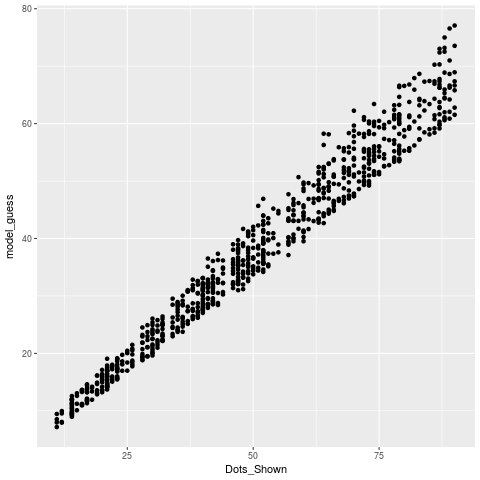

In [62]:
%%R -i summary

means <- summary["mean"]
b_seen <- means["b_seen",]
b_unseen <- means["b_unseen",]
b_noise_seen <- means["b_noise_seen",]
b_noise_unseen <- means["b_noise_unseen",]
b_alpha <- means["alpha",]

data_resp <- data_resp %>%
             mutate(unseen = (Dots_Shown - within_x_tot)) %>%
             mutate(model_guess = b_seen * within_x_tot * ((1/pctArea) ** b_alpha) + 
                        b_unseen * unseen) %>%
             mutate(model_noise = b_noise_seen * within_x_tot + b_noise_unseen * unseen) 

ggplot(data=data_resp) +
        geom_point(aes(x=Dots_Shown, y=model_guess))